## Import used packages

In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import spatial
from math import sin, cos, sqrt, atan2, radians
import folium
from tqdm import tqdm

## Import data

In [2]:
sys.path.insert(0,"..")
bremen_trips = pd.read_csv("../data/processed/trips_weather.csv", index_col=0)
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])

In [3]:
bremen_trips.head(2)

,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,...,dew_point_2m,max_at_2m,mean_speed_h/s,direction_degree_x,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm
0,20685,71,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,...,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0
1,20626,71,10278649,2019-01-20 00:16:00,2019-01-20 04:47:00,16260.0,8.884911,53.078923,8.884911,53.078923,...,-4.8,-3.4,2.6,80.0,3.1,2.1,2.6,80.0,0.0,0.0


## Functions that calculates distance moved towards the university of Bremen and main station

In [4]:
# Function that calculates if start or end location is closer to University of Bremen. 
# Returns the difference of the distances of the start and end location in kilometers.
# If value positive, end locations is closer to university. That means moved towards university.
def distanceToUni(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    uLat = radians(53.1069302) # University of Bremen Latitude
    uLng = radians(8.8499603)  # University of Bremen Longitude

    sdlon = uLng - sLng
    sdlat = uLat - sLat

    edlon = uLng - eLng
    edlat = uLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(uLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(uLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

def distanceToMainStation(sLng,sLat,eLng,eLat):
    # approximate radius of earth in km
    R = 6373.0
    
    sLng = radians(sLng)
    sLat = radians(sLat)
    eLng = radians(eLng)
    eLat = radians(eLat)
    msLat = radians(53.083122) # # Main station Latitude
    msLng = radians(8.813717) # # Main station Latitude

    sdlon = msLng - sLng
    sdlat = msLat - sLat

    edlon = msLng - eLng
    edlat = msLat - eLat

    sA = sin(sdlat / 2)**2 + cos(sLat) * cos(msLat) * sin(sdlon / 2)**2
    eA = sin(edlat / 2)**2 + cos(eLat) * cos(msLat) * sin(edlon / 2)**2
    
    sC = 2 * atan2(sqrt(sA), sqrt(1 - sA))
    eC = 2 * atan2(sqrt(eA), sqrt(1 - eA))

    sDist = R * sC
    eDist = R * eC

    distance = sDist - eDist
    
    return distance

## Example of trip moving away from the university

- Red marker = University of Bremen
- Blue marker = Start location
- Green marker = End location

In [5]:
m = folium.Map(location=[53.1069302,8.8499603], zoom_start=12)

folium.Marker([53.1069302,8.8499603], popup='<i>Uni</i>',icon=folium.Icon(color='red')).add_to(m)
folium.Marker([53.083122,8.813717], popup='<i>Main Station</i>',icon=folium.Icon(color='red')).add_to(m)

row = 2
folium.Marker([bremen_trips.iloc[row,7],bremen_trips.iloc[row,6]], popup='<i>Start</i>').add_to(m)
folium.Marker([bremen_trips.iloc[row,9],bremen_trips.iloc[row,8]], popup='<i>End</i>',icon=folium.Icon(color='green')).add_to(m)

print(distanceToUni(bremen_trips.iloc[row,6],bremen_trips.iloc[row,7],bremen_trips.iloc[row,8],bremen_trips.iloc[row,9]))

m

-0.6630672878488006


## Add to_uni, to_main_station and direction attribute to trips data

In [7]:
to_uni = []
to_main_station = []
to_uni_bool = []
to_main_station_bool = []

for index, row in tqdm(bremen_trips.iterrows()):
    dist_to_uni = distanceToUni(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    dist_to_main_station = distanceToMainStation(row['start_lng'],row['start_lat'],row['end_lng'],row['end_lat'])
    
    # Save distances to corresponding list
    to_uni.append(dist_to_uni)
    to_main_station.append(dist_to_main_station)
    
    if dist_to_uni < 0:
        to_uni_bool.append(0)
    else:
        to_uni_bool.append(1)
        
    if dist_to_main_station < 0:
        to_main_station_bool.append(0)
    else:
        to_main_station_bool.append(1)
        

bremen_trips['to_uni'] = to_uni
bremen_trips['to_main_station'] = to_main_station
bremen_trips['to_uni_bool'] = to_uni_bool
bremen_trips['to_main_station_bool'] = to_main_station_bool

143665it [00:25, 5721.76it/s]


In [8]:
bremen_trips.sample(3)

,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,...,max_m/s,min_mean_m/s,max_mean_m/s,direction_degree_y,min,mm,to_uni,to_main_station,to_uni_bool,to_main_station_bool
29314,20875,71,14922292,2019-04-24 21:25:00,2019-04-24 21:39:00,840.0,8.834542,53.066988,8.806337,53.073178,...,10.3,4.1,6.9,100.0,0.0,0.0,-0.191954,1.059835,0,1
8182,20724,71,12973937,2019-02-25 13:56:00,2019-02-25 14:06:00,600.0,8.806603,53.075089,8.828508,53.077280,...,2.6,0.5,1.9,300.0,0.0,0.0,0.979271,-0.170697,1,0
74949,20767,71,20494961,2019-08-14 18:28:00,2019-08-14 19:23:00,3300.0,8.813365,53.101822,8.803467,53.101858,...,2.6,1.5,2.0,200.0,0.0,0.0,-0.646659,-0.113416,0,0


## Check on correlations to_uni

In [10]:
bremen_trips.drop(columns={'end_lng','end_lat','end_place','end_plz','to_uni','to_uni_bool','to_main_station_bool','to_main_station','duration_sec','duration_min','identification'}).corrwith(bremen_trips['to_uni'])

bike                  0.000211
bike_type            -0.000414
start_lng            -0.182360
start_lat            -0.308355
start_place          -0.025935
start_plz            -0.107646
month                 0.001459
weekdays             -0.003260
temp_2m              -0.001132
humidity_2m           0.002514
dew_point_2m          0.001915
max_at_2m            -0.001046
mean_speed_h/s        0.001006
direction_degree_x    0.002561
max_m/s               0.000813
min_mean_m/s         -0.000848
max_mean_m/s          0.000691
direction_degree_y    0.001673
min                   0.004558
mm                    0.000559
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.1

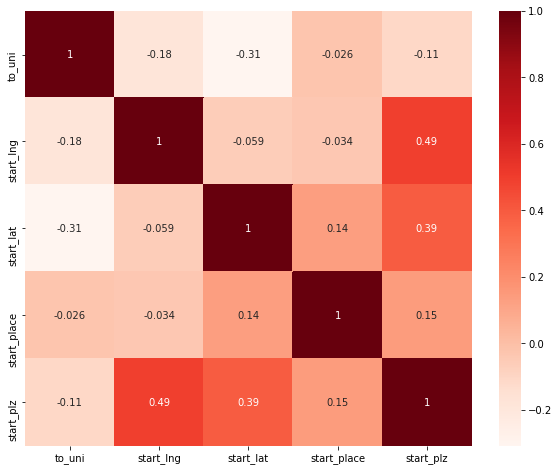

In [11]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_uni','start_lng','start_lat','start_place','start_plz']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Check on correlations to_main_station

In [12]:
bremen_trips.drop(columns={'end_lng','end_lat','end_place','to_uni_bool','to_main_station_bool','end_plz','to_uni','to_main_station','duration_sec','duration_min','identification'}).corrwith(bremen_trips['to_main_station'])

bike                  0.001294
bike_type            -0.001140
start_lng             0.108525
start_lat             0.012228
start_place           0.096367
start_plz             0.260688
month                 0.001435
weekdays             -0.007885
temp_2m               0.011380
humidity_2m          -0.020918
dew_point_2m         -0.001854
max_at_2m             0.011266
mean_speed_h/s        0.012922
direction_degree_x    0.003631
max_m/s               0.014764
min_mean_m/s          0.007857
max_mean_m/s          0.013898
direction_degree_y    0.004054
min                   0.002794
mm                    0.000886
dtype: float64

### Pearson correlation only for attributes with correlation higher than 0.1

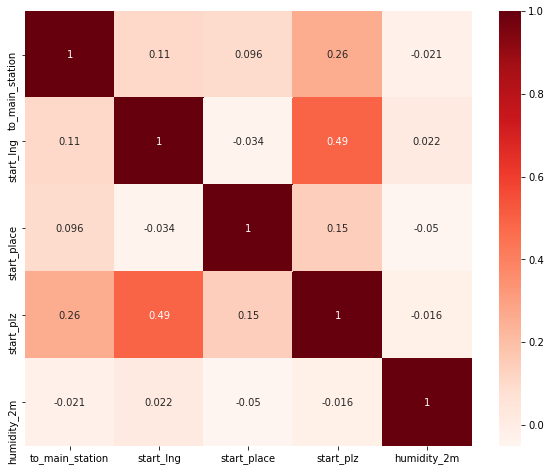

In [13]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = bremen_trips[['to_main_station','start_lng','start_place','start_plz','humidity_2m']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Predicting to_uni - Regression

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [15]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz']]
y = bremen_trips['to_uni']

### Polynomial regression

In [ ]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

In [ ]:
poly = PolynomialFeatures(4)
X_train_poly = poly.fit_transform(X_train)

In [ ]:
lin = LinearRegression()

In [ ]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

In [ ]:
X_val_poly = poly.fit_transform(X_val)
lin.score(X_val_poly,y_val)

In [16]:
def chooseDegree(X, y):
    
    # Splitting data into train and validation set
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

    acc_train = []
    acc_val = []
    rmses_val = []
    degrees = np.arange(1, 15)
    min_rmse, min_deg = 1e10, 0

    for deg in degrees:

        # Train features
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly_train = poly_features.fit_transform(X_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly_train, y_train)
        X_val_poly = poly_features.fit_transform(X_val)
        
        # Evaluate
        acc_train.append(poly_reg.score(X_poly_train, y_train))
        acc_val.append(poly_reg.score(X_val_poly,y_val))

        # Compare with val data
        poly_predict = poly_reg.predict(X_val_poly)
        poly_mse = mean_squared_error(y_val, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        rmses_val.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Suggested degree {} with RMSE of validation set {}'.format(min_deg, min_rmse))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    #ax_rmses_val = fig.add_subplot(111)
    axes[0].plot(degrees, rmses_val, label='rmses_val')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('RMSE')
    
    #ax_acc_train = fig.add_subplot(111)
    axes[1].plot(degrees, acc_train, label='acc_train')
    axes[1].set_yscale('linear')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Acc_train')
    axes[1].set_label('Acc_train')
    
    #ax_acc_val = fig.add_subplot(111)
    axes[1].plot(degrees, acc_val, label='acc_val')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Acc_val')
    
    axes[0].legend()
    axes[1].legend()
    fig.tight_layout()

Suggested degree 4 with RMSE of validation set 1.2104183741704737


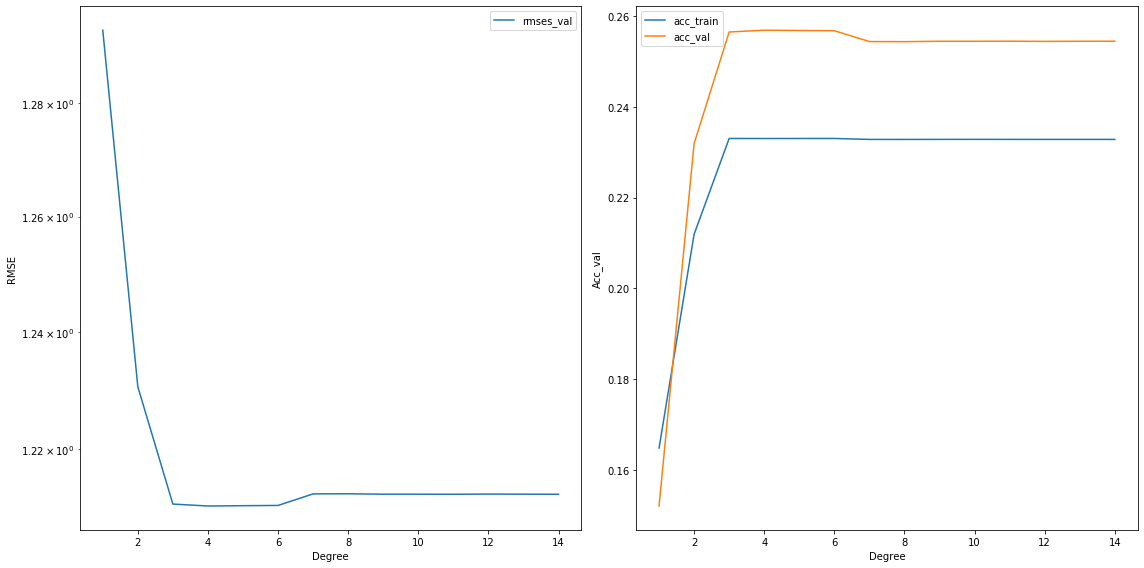

In [17]:
chooseDegree(X,y)

# Predicting to_main_station - Regression

In [18]:
# Initialize independent and target variable
X = bremen_trips.dropna()[['start_lng','start_place','start_plz','humidity_2m']]
y = bremen_trips.dropna()['to_main_station']

Suggested degree 9 with RMSE of validation set 1.4979760630539147


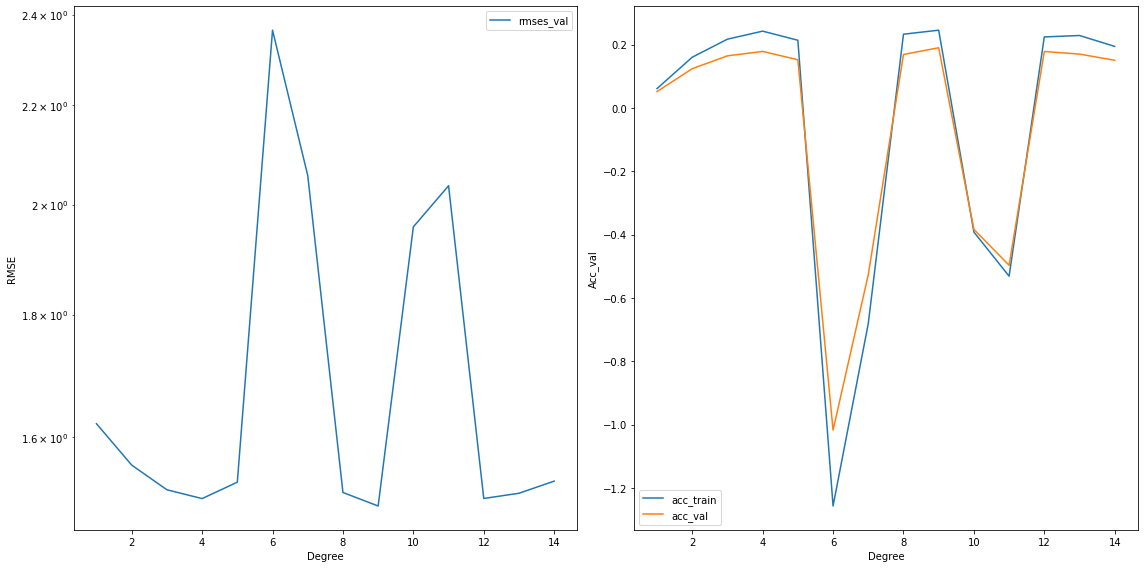

In [19]:
chooseDegree(X,y)

# Predicting to_uni_bool - Classification

### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [132]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','month']]
y = bremen_trips['to_uni_bool']

In [133]:
# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

In [134]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [135]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.9334040998155431
Valiation accuracy: 0.6378375242901476


In [136]:
rf.score(X_val, y_val)

0.6378375242901476

In [137]:
rf.predict_proba(X_val)

array([[0.58, 0.42],
       [0.  , 1.  ],
       [0.06, 0.94],
       ...,
       [0.56, 0.44],
       [0.25, 0.75],
       [0.19, 0.81]])

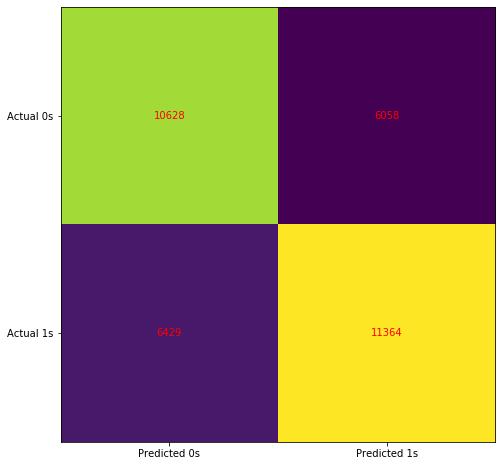

In [138]:
cm = confusion_matrix(y_val, rf.predict(X_val))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [139]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     16686
           1       0.65      0.64      0.65     17793

    accuracy                           0.64     34479
   macro avg       0.64      0.64      0.64     34479
weighted avg       0.64      0.64      0.64     34479



### Performing grid search to optimize hyperparameters

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [141]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='accuracy', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [142]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.63569138 0.63801157 0.63777957 0.6382727  0.63705448 0.63815667
 0.63815667 0.62728048 0.64053494 0.64105703 0.64070898 0.64041891
 0.64137613 0.64198521 0.63670654 0.65207801 0.65393423 0.651092
 0.65109204 0.65436924 0.65399224 0.64442115 0.65323813 0.65384723
 0.65373127 0.65399229 0.65454338 0.6541083  0.64679933 0.65590648
 0.6574436  0.65706655 0.65695057 0.65645751 0.65735663]
25 7 42


In [143]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [144]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6604078933630321
Valiation accuracy: 0.6572116360683314


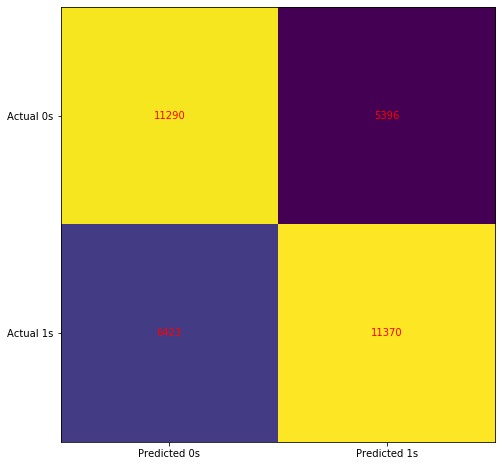

In [145]:
cm = confusion_matrix(y_val, rf.predict(X_val))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [146]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.64      0.68      0.66     16686
           1       0.68      0.64      0.66     17793

    accuracy                           0.66     34479
   macro avg       0.66      0.66      0.66     34479
weighted avg       0.66      0.66      0.66     34479



# Evaluation on test data - the moment of truth

In [147]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6597254447022428


# Try Logistic regression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [95]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','month']]
y = bremen_trips['to_uni_bool']

In [96]:
# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

In [97]:
model = LogisticRegression(solver='liblinear',multi_class='ovr', random_state=42, class_weight='balanced').fit(X_train, y_train)

In [ ]:
print('Training accuracy: ' + str(model.score(X_train, y_train)))
print('Valiation accuracy: ' + str(model.score(X_val, y_val)))

In [98]:
model.predict_proba(X_val)

array([[0.57249259, 0.42750741],
       [0.47400741, 0.52599259],
       [0.60789319, 0.39210681],
       ...,
       [0.49814994, 0.50185006],
       [0.58928441, 0.41071559],
       [0.61482325, 0.38517675]])

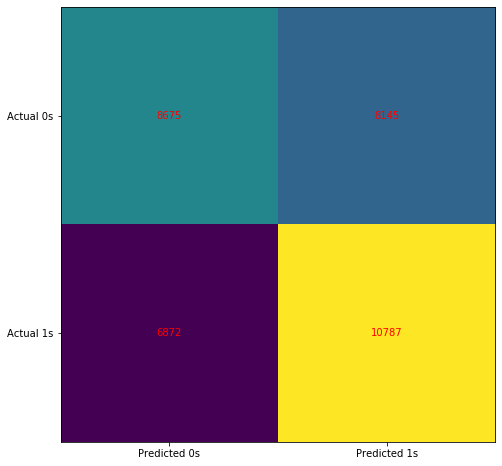

In [100]:
cm = confusion_matrix(y_val, model.predict(X_val))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [101]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54     16820
           1       0.57      0.61      0.59     17659

    accuracy                           0.56     34479
   macro avg       0.56      0.56      0.56     34479
weighted avg       0.56      0.56      0.56     34479



### Logistic regression performs worst than random forest. Do not use it!

# Predicting to_main_station_bool - Classification

In [115]:
# Initialize independent and target variable
X = bremen_trips[['start_lng','start_lat','start_plz','month']]
y = bremen_trips['to_main_station_bool']

In [116]:
# Splitting data into train and validation set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=True)

In [104]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [110]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.9379111126579195
Valiation accuracy: 0.6802111430145886


In [111]:
rf.predict_proba(X_val)

array([[0.80437053, 0.19562947],
       [0.45      , 0.55      ],
       [0.82      , 0.18      ],
       ...,
       [0.        , 1.        ],
       [0.56781835, 0.43218165],
       [0.11728279, 0.88271721]])

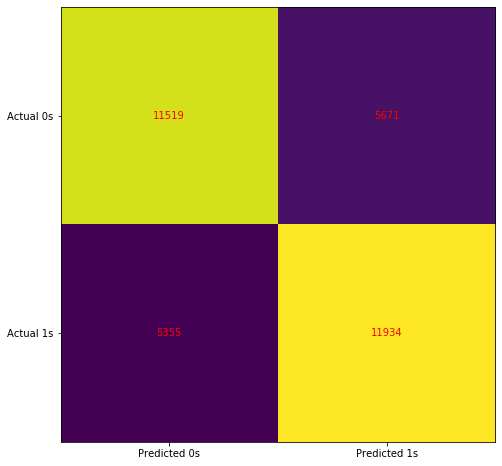

In [112]:
cm = confusion_matrix(y_val, rf.predict(X_val))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [113]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.68      0.67      0.68     17190
           1       0.68      0.69      0.68     17289

    accuracy                           0.68     34479
   macro avg       0.68      0.68      0.68     34479
weighted avg       0.68      0.68      0.68     34479



### Performing grid search to optimize hyperparameters

In [120]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='accuracy', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [121]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.61802861 0.63760518 0.63693813 0.63688012 0.68015334 0.65190506
 0.64999072 0.63905572 0.68082038 0.68264754 0.68296657 0.68308264
 0.68348867 0.6831116  0.65874881 0.68177732 0.68160349 0.68250258
 0.68302462 0.68270556 0.6833436  0.66924767 0.68450373 0.68569295
 0.6851129  0.68607004 0.68470685 0.68525791 0.67609254 0.68986938
 0.6898985  0.68928943 0.6898695  0.68981148 0.68995649]
512 7 42


In [123]:
rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=512, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Evaluation

In [124]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.6949152542372882
Valiation accuracy: 0.6877809681255257


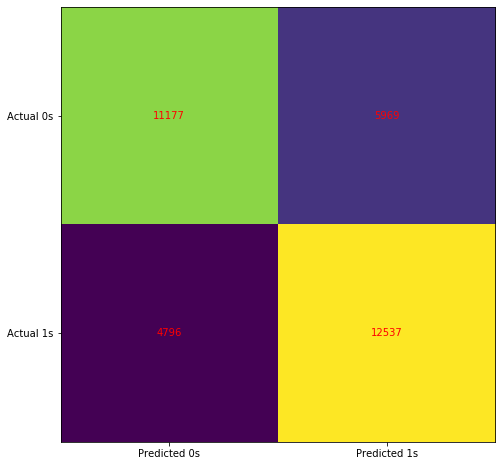

In [126]:
cm = confusion_matrix(y_val, rf.predict(X_val))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [127]:
print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67     17146
           1       0.68      0.72      0.70     17333

    accuracy                           0.69     34479
   macro avg       0.69      0.69      0.69     34479
weighted avg       0.69      0.69      0.69     34479



# Evaluation on test data - the moment of truth

In [131]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: 0.6918406805877804
